# Homework 3


In [184]:
import pandas as pd
import numpy as np
from Binomial_Fixed import binomial, ratecurves
from Binomial_Fixed import ficcvol
from treasury_cmds import *
import scipy
from scipy.optimize import fsolve
from scipy.stats import norm
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [185]:
from Binomial_Fixed.binomial import *

In [186]:
future_bonds = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/fut_bond_data_FVU3_2023-04-21.xlsx'
bdt_path = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/bdt_params_freq52_2023-04-21.xlsx'
future_description = pd.read_excel(future_bonds, sheet_name='future').set_index('field')
bond_info = pd.read_excel(future_bonds,sheet_name='bonds').set_index('ticker')
bdt_params = pd.read_excel(bdt_path).set_index('maturity')
col = 'FVU3 Comdty'
Future_Price = future_description.loc['px_last',col]
DATE = '2023-04-21'
FUT_DAYS_EXPIRE = 159



In [187]:
future_description


,FVU3 Comdty
field,
last_update_dt,2023-04-21 00:00:00
px_last,109.789062
last_tradeable_dt,2023-09-29 00:00:00
fut_dlv_dt_last,2023-10-04 00:00:00
fut_days_expire,159
fut_ctd,T 3.875 11/30/27
fut_ctd_px,100.757812
fut_ctd_gross_basis,-17.074348
fut_ctd_net_basis,1.199828


## 1.1 Trading Bonds

Give brief answers to these based on the market quotes provided,
### 1.1.1
Calculate the 
* gross basis
* carry
* net basis for each bond

### 1.1.2
Which bond seems most likely to be CTD?

### 1.1.3
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

In [188]:
future_description

,FVU3 Comdty
field,
last_update_dt,2023-04-21 00:00:00
px_last,109.789062
last_tradeable_dt,2023-09-29 00:00:00
fut_dlv_dt_last,2023-10-04 00:00:00
fut_days_expire,159
fut_ctd,T 3.875 11/30/27
fut_ctd_px,100.757812
fut_ctd_gross_basis,-17.074348
fut_ctd_net_basis,1.199828


In [189]:
future_description.loc['fut_days_expire',col]

159

In [190]:
px = bond_info['px_last']
gross_basis = (px - Future_Price*bond_info['conversion']).to_frame().rename(columns = {0:"Dollars"})
gross_basis['32nds'] = gross_basis['Dollars']*32
gross_basis.columns.name = "Gross Basis"
gross_basis

Gross Basis,Dollars,32nds
ticker,,
91282CFZ Govt,-0.533577,-17.074450
91282CGC Govt,-0.387684,-12.405900
91282CGH Govt,-0.251620,-8.051850
91282CGP Govt,0.105155,3.364950
91282CGT Govt,0.194551,6.225625


**Calculating Net Basis**

In [191]:
bond_info

,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,
91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


In [192]:
px_dirty

ticker
91282CFZ Govt    102.301425
91282CGC Govt    101.970304
91282CGH Govt     99.997799
91282CGP Govt    102.082201
91282CGT Govt    100.065830
dtype: float64

In [193]:
days_settle = 0
FACE = 100
cpn = bond_info['cpn']/100
repo = bond_info['repo_reporate']/100
days_fwd = future_description.loc['fut_days_expire',col] - days_settle
days_cpn_period = bond_info['accrued_days_between_cpn_dates']
days_already_accrued = bond_info['days_acc']+ days_settle
int_accrued = cpn*(FACE/2) * (days_already_accrued/days_cpn_period)
px_dirty = px + int_accrued
carry = ((FACE*cpn - repo*px_dirty)* (days_fwd/360)).to_frame().rename(columns = {0:'Dollars'})
carry['32nds'] = carry['Dollars']*32
net_basis = gross_basis-carry
net_basis

Gross Basis,Dollars,32nds
ticker,,
91282CFZ Govt,-0.069467,-2.222951
91282CGC Govt,0.069383,2.220265
91282CGH Govt,0.329125,10.531985
91282CGP Govt,0.509394,16.300596
91282CGT Govt,0.721534,23.089090


**Calculating Net Basis Using Forward Prices**

In [194]:
days_next_cpn_period = 365 - days_cpn_period
days_next_cpn = bond_info['days_to_next_coupon']-days_settle
days_past_cpn = (days_fwd-days_next_cpn)
int_post_accrual = cpn*FACE/2 * (days_past_cpn/days_next_cpn_period)

fwd_price =  ((px + int_accrued)*(1+repo*days_next_cpn/360)-FACE*cpn/2)*(1+repo *days_past_cpn/360) - int_post_accrual
fwd_price

ticker
91282CFZ Govt    101.224472
91282CGC Govt    101.219983
91282CGH Govt     99.790630
91282CGP Govt    101.920657
91282CGT Govt    100.381355
dtype: float64

## Converstion Factors

In [195]:
NOMDISC = 0.06
Tmat_at_expiration = (bond_info['days_to_mty']- future_description.loc['fut_days_expire',col])/365.25
converts = ratecurves.price_bond(NOMDISC,Tmat_at_expiration,bond_info['cpn']/100,face = 100,accr_frac=0)/100
pd.concat([converts,bond_info['conversion']], axis = 1)

,0,conversion
ticker,,
91282CFZ Govt,0.922669,0.9226
91282CGC Govt,0.921283,0.9212
91282CGH Govt,0.905770,0.9058
91282CGP Govt,0.923408,0.9234
91282CGT Govt,0.907522,0.9075


### BDT Model

In this problem you will make use of a BDT modeled binomial tree.

To save you some time, you are provided the parameters of a BDT tree fit to both swaps and caps.
* Use the file `bdt_params_freq52_2023-04-21.xlsx`
* With these $\sigma$ and $\theta$ parameters, you should be able to build a BDT tree with $T=5$ and $dt=1/52$.

#### Note
If interested in how this was done, find the data and files used to get these parameters. In particular, 
* The market quotes interpolated to weekly frequency: `cap_curves_2023-04-21_freq_52.xlsx`.
* The file to estimate the model is `Parameterize BDT.ipynb`.

## 1.3 BDT Tree

Report the number of steps for
* each bond's maturity
* the futures contract expiration

Build the interest-rate tree and display it.

In [196]:
FREQ = 52

In [197]:
Tcpns = align_days_interval_to_tree_periods(bond_info['days_to_next_coupon'],freq = FREQ)
Tmats = align_days_interval_to_tree_periods(bond_info['days_to_mty'],FREQ)
Texpry = align_days_interval_to_tree_periods(future_description.loc['fut_days_expire',col],FREQ)
Tmats


ticker
91282CFZ Govt    4.596154
91282CGC Govt    4.692308
91282CGH Govt    4.769231
91282CGP Govt    4.846154
91282CGT Govt    4.942308
Name: days_to_mty, dtype: float64

In [198]:
ratetree = BDTtree(bdt_params['theta'],bdt_params['fwd vol'],px_bond0=bdt_params['discount'].iloc[0],dt = 1/FREQ)
ratetree.loc[:,:Texpiry].dropna(how = 'all').style.format("{:.2%}",na_rep = '')


time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,0.192308,0.211538,0.230769,0.250000,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,,,,
0,4.89%,5.09%,5.31%,5.51%,5.71%,5.90%,6.09%,6.29%,6.48%,6.67%,6.87%,7.07%,7.27%,7.47%,7.68%,7.90%,8.12%,8.34%,8.58%,8.82%,9.07%,9.32%,9.59%,9.87%
1,,4.77%,4.97%,5.16%,5.35%,5.53%,5.71%,5.89%,6.07%,6.25%,6.44%,6.62%,6.81%,7.00%,7.20%,7.40%,7.61%,7.82%,8.04%,8.26%,8.50%,8.74%,8.99%,9.25%
2,,,4.66%,4.84%,5.01%,5.18%,5.35%,5.52%,5.69%,5.86%,6.03%,6.21%,6.38%,6.56%,6.75%,6.94%,7.13%,7.33%,7.53%,7.74%,7.96%,8.19%,8.42%,8.67%
3,,,,4.56%,4.73%,4.89%,5.05%,5.21%,5.36%,5.53%,5.69%,5.85%,6.02%,6.19%,6.36%,6.54%,6.72%,6.91%,7.10%,7.30%,7.51%,7.72%,7.94%,8.17%
4,,,,,4.47%,4.62%,4.77%,4.92%,5.07%,5.22%,5.38%,5.53%,5.69%,5.85%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%,7.51%,7.72%
5,,,,,,4.37%,4.51%,4.65%,4.79%,4.94%,5.08%,5.23%,5.38%,5.53%,5.69%,5.84%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%
6,,,,,,,4.26%,4.40%,4.53%,4.67%,4.80%,4.94%,5.08%,5.23%,5.38%,5.53%,5.68%,5.84%,6.00%,6.17%,6.34%,6.52%,6.71%,6.90%
7,,,,,,,,4.15%,4.28%,4.41%,4.54%,4.67%,4.80%,4.94%,5.08%,5.22%,5.36%,5.51%,5.67%,5.83%,5.99%,6.16%,6.34%,6.52%
8,,,,,,,,,4.04%,4.16%,4.28%,4.40%,4.53%,4.66%,4.79%,4.92%,5.06%,5.20%,5.34%,5.49%,5.65%,5.81%,5.98%,6.15%


## 1.4 Bond Pricing

Use the tree to price each bond. Report
* time-0 dirty and clean price of each bond
* terminal (clean) value of each bond at futures expiration, for each state of the tree.

Thus, to report the terminal values you will need to grab the expiration column of each bond's (clean) pricing tree and adjust (inflate) it for the conversion factor.

In [199]:
FACE = 100
compound = FREQ
dt = 1/compound
cpn_freq = 2


In [200]:
terminalvals = pd.DataFrame(dtype = float, index = ratetree.index,columns = bond_info.index)
px_bonds_bdt = pd.DataFrame(dtype = float, index = bond_info.index, columns = ['Clean'])
px_bonds_dirty = pd.DataFrame(dtype=float,index = bond_info.index, columns=['Dirty'] )



In [201]:
for j, bond in enumerate(bond_info.index):
    tsteps = round(Tmats[j]/dt)
    cpn = bond_info.loc[bond,'cpn']/100
    wrapper_bond = lambda r : payoff_bond(r, dt, facevalue=FACE*(1 + cpn/cpn_freq))

    cftree = construct_bond_cftree(T = Tmats[j], compound = compound, cpn = cpn)
    if Tcpns[j] == 0:
        cftree.loc[0,0] += cpn/2
    bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
    accint = construct_accint(bondtree.columns.values, compound, cpn)
    px_bonds_dirty.loc[bond] = bondtree.iloc[0,0]
    cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)
    px_bonds_bdt.loc[bond] = cleantree.iloc[0,0]
    
    terminalvals[bond] = cleantree[Texpry]

terminalvals.dropna(inplace=True)

    

In [202]:
pd.concat([px_bonds_bdt,bond_info['px_last'], px_bonds_dirty], axis = 1)

,Clean,px_last,Dirty
ticker,,,
91282CFZ Govt,100.715335,100.757812,102.280239
91282CGC Govt,100.739787,100.750000,101.932095
91282CGH Govt,99.142046,99.195312,99.949739
91282CGP Govt,101.320874,101.484375,101.936259
91282CGT Govt,99.686176,99.828125,99.895311


In [203]:
terminalvals

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
state,,,,,
0,54.190817,53.679552,52.200684,53.266976,51.715786
1,59.713179,59.213908,57.692757,58.834005,57.236961
2,65.156443,64.681234,63.129166,64.351855,62.721681
3,70.434948,69.994864,68.423046,69.732352,68.081659
4,75.475907,75.080452,73.499272,74.898803,73.239460
5,80.219954,79.876688,78.295346,79.786970,78.129611
6,84.623048,84.337375,82.763592,84.347387,82.701043
7,88.656832,88.431952,86.871808,88.546139,86.918019
8,92.307822,92.144841,90.602748,92.364436,90.759862


## 1.5 CTD

Use your terminal values calculated above to state which bond is CTD in each interest-rate state (at this expiration node.) 

Report the duration of each bond (as of today's price, not recomputed for the interest-rate nodes.) Do you see a relationship between the time-0 duration and the at-expiration CTD?

In [204]:
quality = terminalvals.copy().divide(converts,axis = 1)
quality.index = ratetree.loc[:,Texpry].dropna()
quality.style.highlight_min(color = 'green', axis = 1).format('{:.2f}')

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
0.442308,,,,,
0.098691,58.73,58.27,57.63,57.69,56.99
0.092487,64.72,64.27,63.69,63.71,63.07
0.086673,70.62,70.21,69.70,69.69,69.11
0.081727,76.34,75.98,75.54,75.52,75.02
0.077236,81.80,81.50,81.15,81.11,80.70
0.073037,86.94,86.70,86.44,86.40,86.09
0.069043,91.72,91.54,91.37,91.34,91.13
0.065205,96.09,95.99,95.91,95.89,95.78
0.061496,100.04,100.02,100.03,100.03,100.01


In [205]:
bondstats = pd.DataFrame(dtype=float, index = bond_info.index, columns=['px_last','cpn','ytm','duration','conversion'])
for idx, bond in enumerate(bond_info.index):
    T = bond_info.loc[bond,'days_to_mty']/365.25
    cpn =bond_info.loc[bond,'cpn']/100
    bondstats.loc[bond,'cpn'] = cpn
    accfrac = bond_info.loc[bond,'days_acc']/bond_info.loc[bond,'accrued_days_between_cpn_dates']
    bondstats.loc[bond,'px_last'] = bond_info.loc[bond,'px_last']
    p = bond_info.loc[bond,'px_last']
    bondstats.loc[bond,'conversion'] = bond_info.loc[bond,'conversion']
    bondstats.loc[bond,'ytm'] = ratecurves.ytm(p,T = T, cpn = cpn,cpnfreq=2,face = 100,accr_frac=accfrac)
    bondstats.loc[bond,'duration'] = ratecurves.duration_closed_formula(tau = T, ytm = bondstats.loc[bond,'ytm'],cpnrate=cpn,freq = 2)

In [206]:
bondstats

,px_last,cpn,ytm,duration,conversion
ticker,,,,,
91282CFZ Govt,100.757812,0.03875,0.040795,4.257591,0.9226
91282CGC Govt,100.750000,0.03875,0.039922,4.329998,0.9212
91282CGH Govt,99.195312,0.03500,0.038884,4.432692,0.9058
91282CGP Govt,101.484375,0.04000,0.037915,4.459884,0.9234
91282CGT Govt,99.828125,0.03625,0.037173,4.563210,0.9075


## 1.6 Futures Price

Model the futures price with the tree approach.
* Use the CTD terminal value for each rate.
* Step backward through the tree.

As you step backward remember that for a futures contract
* no discounting by the riskfree rate
* the futures contract has no capital requirement and thus an expected P&L of zero under this measure.

Thus, each node is the simple average of the two nodes at the following step.

**Report the futures price.**

### Compare
How does it compare to 
* the quoted futures price
* the modeled bond prices

In [207]:
payoff_func = lambda r: (terminalvals/converts).min(axis = 1).values
ratetree_fwd_measure = ratetree.copy().loc[:,:Texpry].dropna(how = 'all')
ratetree_fwd_measure *= 0

futtree = bintree_pricing(payoff=payoff_func,ratetree=ratetree_fwd_measure)
futtree.head(4)


time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,
0,109.733681,108.483577,107.146463,105.717779,104.192974,102.567635,100.837666,98.999555,97.050700,94.989779,...,83.079495,80.413661,77.669611,74.854741,71.976973,69.045180,66.069144,63.059492,60.027637,56.985739
1,NaN,110.983785,109.820690,108.575147,107.242583,105.818314,104.297603,102.675777,100.948410,99.111620,...,88.240055,85.745330,83.157711,80.484480,77.732509,74.908765,72.021216,69.078796,66.091347,63.069535
2,NaN,NaN,112.146879,111.066233,109.907712,108.666853,107.339025,105.919430,104.403143,102.785200,...,93.029135,90.734780,88.332949,85.830941,83.236451,80.556253,77.796314,74.963636,72.066245,69.113160
3,NaN,NaN,NaN,113.227525,112.224754,111.148570,109.994681,108.758619,107.435717,106.021086,...,97.391946,95.323490,93.136611,90.834958,88.425430,85.916649,83.316192,80.628992,77.861027,75.019331


**Comparison**

In [208]:
bond_comps = pd.concat([bond_info['px_last'],px_bonds_bdt],axis = 1).rename(columns={'px_last':'quote','Clean':'model'})

bond_comps_converted = bond_comps.copy().divide(converts,axis =0)
bond_comps_converted

,quote,model
ticker,,
91282CFZ Govt,109.202557,109.156519
91282CGC Govt,109.358310,109.347224
91282CGH Govt,109.514855,109.456047
91282CGP Govt,109.901942,109.724880
91282CGT Govt,110.000832,109.844419


In [209]:
Future_Price

109.7890625

In [210]:
converts

ticker
91282CFZ Govt    0.922669
91282CGC Govt    0.921283
91282CGH Govt    0.905770
91282CGP Govt    0.923408
91282CGT Govt    0.907522
dtype: float64

# 2. Fed Funds Futures

The file `data/fedfutures_2023-04-21.xlsx`jj has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2024.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2023-04-21`.

In [226]:
fed_file = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/fedfutures_2023-04-21.xlsx'
fed_futures = pd.read_excel(fed_file, sheet_name = 'fed futures').set_index('ticker')
fed_funds = pd.read_excel(fed_file,sheet_name='fed funds').set_index('ticker')
fed_futures_historic = pd.read_excel(fed_file,sheet_name='fed futures historic').set_index('ticker')
fed_meetings = pd.read_excel(fed_file,sheet_name='fed meetings')


In [227]:
fed_meetings

,meeting dates
0,2023-05-03
1,2023-06-14
2,2023-07-26
3,2023-09-20
4,2023-11-01
5,2023-12-13
6,2024-01-26
7,2024-03-22
8,2024-05-03
9,2024-06-14


## 2.1 Chart the Fed Futures Rates

Chart the Fed Funds curve at
* the present date
* the historic date

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

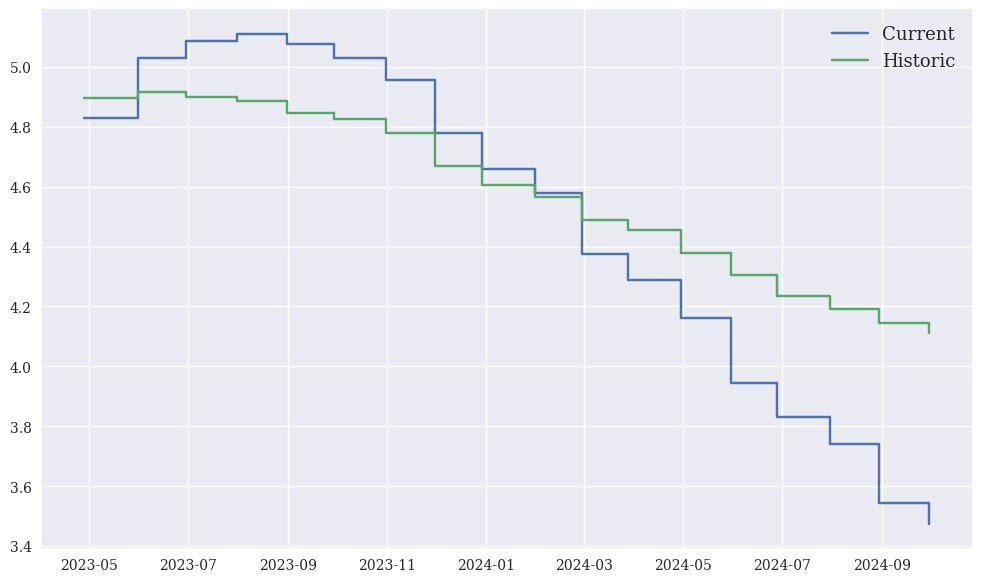

In [228]:
plt.figure(figsize = (12,7))
plt.step(fed_futures['last_tradeable_dt'],100 -fed_futures['px_last'],where = 'post' ,label = "Current")
plt.step(fed_futures['last_tradeable_dt'],100 -fed_futures_historic.iloc[:,0],where = 'post',label = 'Historic')
plt.legend(loc = 0)

## 2.2 Extracting the Expected Path of Fed Funds Rates

The Fed has a great deal of control over the Fed Funds Rate. We simplify by assuming the Fed 
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Note
One (minor) assumption:
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.
* Here, use the simpler method #1--that is, for months with no meeting in the following month, the calculation is very simple.

In [229]:
fed_funds.loc['FEDL01 Index']

px_last                  4.83
short_name    EFFR Continuous
date               2023-04-21
Name: FEDL01 Index, dtype: object

In [230]:
fedfutures = fed_futures[['last_tradeable_dt','px_last']]
r0 = fed_funds.loc['FEDL01 Index','px_last']/100
curve = ratecurves.extract_fedpath(fed_futures,fed_meetings,r0)

c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curves['expected fed rate'].iloc[step] = Eprev
c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curves['expected fed rate'].iloc[step] = (n * curves['futures rate'].iloc[step] - m * Eprev)/(n-m)
c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/p

In [231]:
r0Hist = (100 - fed_futures_historic.iloc[0,0])/100
curveH = ratecurves.extract_fedpath(fedfutures,fed_meetings,r0Hist)

c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curves['date'] = tag
c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curves['expected fed rate'].iloc[step] = Eprev
c:\Users\dcste\anaconda3\lib\site-packages\Binomial_Fixed\ratecurves.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [232]:
curveH


,ticker,last_tradeable_dt,meeting dates,meeting day,contract days,futures rate,expected fed rate
date,,,,,,,
2023-04,FFJ3 Comdty,2023-04-28,NaT,NaN,28,0.04830,0.048950
2023-05,FFK3 Comdty,2023-05-31,2023-05-03,3.0,31,0.05030,0.050445
2023-06,FFM3 Comdty,2023-06-30,2023-06-14,14.0,30,0.05085,0.051205
2023-07,FFN3 Comdty,2023-07-31,2023-07-26,26.0,31,0.05110,0.050750
2023-08,FFQ3 Comdty,2023-08-31,NaT,NaN,31,0.05075,0.050750
2023-09,FFU3 Comdty,2023-09-29,2023-09-20,20.0,29,0.05030,0.049550
2023-10,FFV3 Comdty,2023-10-31,NaT,NaN,31,0.04955,0.049550
2023-11,FFX3 Comdty,2023-11-30,2023-11-01,1.0,30,0.04780,0.047740
2023-12,FFZ3 Comdty,2023-12-29,2023-12-13,13.0,29,0.04660,0.045674


In [233]:
curve = curve.join(curveH.iloc[:,-2:],rsuffix= ' historic')
curve

,ticker,px_settle_last_dt,open_int,fut_days_expire,last_tradeable_dt,meeting dates,meeting day,contract days,futures rate,expected fed rate,futures rate historic,expected fed rate historic
date,,,,,,,,,,,,
2023-04,FFJ3 Comdty,2023-04-21,476641,4,2023-04-28,NaT,NaN,28,0.04830,0.048300,0.04830,0.048950
2023-05,FFK3 Comdty,2023-04-21,358403,37,2023-05-31,2023-05-03,3.0,31,0.05030,0.050514,0.05030,0.050445
2023-06,FFM3 Comdty,2023-04-21,138731,67,2023-06-30,2023-06-14,14.0,30,0.05085,0.051144,0.05085,0.051205
2023-07,FFN3 Comdty,2023-04-21,260804,98,2023-07-31,2023-07-26,26.0,31,0.05110,0.050750,0.05110,0.050750
2023-08,FFQ3 Comdty,2023-04-21,233265,129,2023-08-31,NaT,NaN,31,0.05075,0.050750,0.05075,0.050750
2023-09,FFU3 Comdty,2023-04-21,39114,158,2023-09-29,2023-09-20,20.0,29,0.05030,0.049550,0.05030,0.049550
2023-10,FFV3 Comdty,2023-04-21,120233,190,2023-10-31,NaT,NaN,31,0.04955,0.049550,0.04955,0.049550
2023-11,FFX3 Comdty,2023-04-21,70094,220,2023-11-30,2023-11-01,1.0,30,0.04780,0.047740,0.04780,0.047740
2023-12,FFZ3 Comdty,2023-04-21,24557,249,2023-12-29,2023-12-13,13.0,29,0.04660,0.045674,0.04660,0.045674


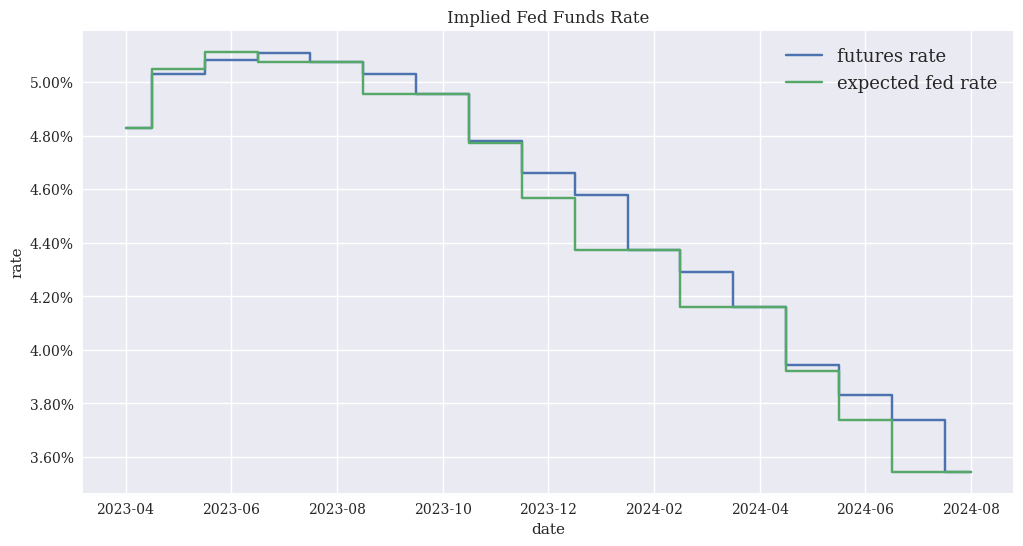

In [234]:
curveplot = curve[['futures rate','expected fed rate']].dropna(subset='expected fed rate')
ax = curveplot.plot(drawstyle='steps-mid');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate');

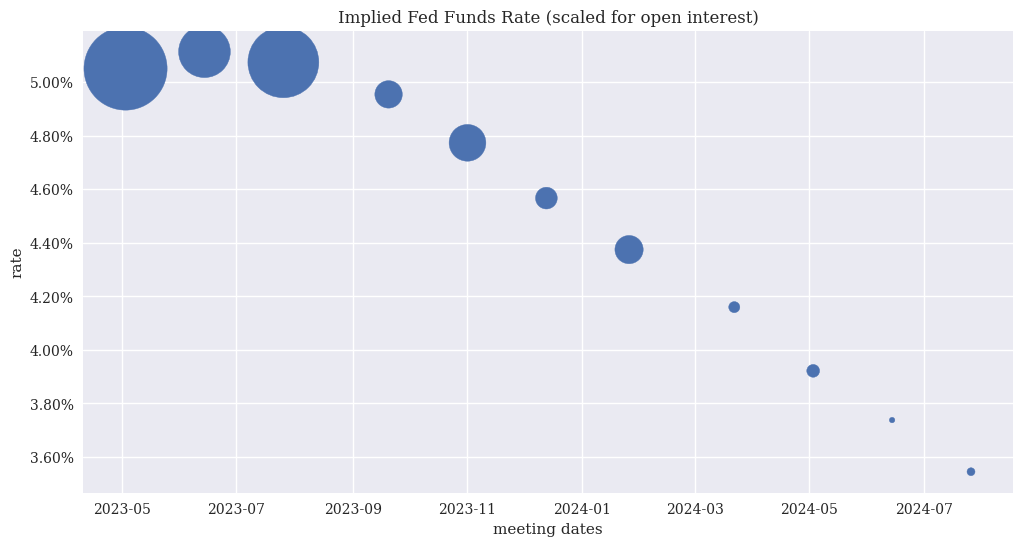

In [235]:
ax = curve.plot.scatter(x='meeting dates', y='expected fed rate', s=fed_futures['open_int']/100);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate (scaled for open interest)');